In [1]:
!pip install easyocr

     |████████████████████████████████| 48.4MB 63kB/s 


In [2]:
!pip install pyngrok

  Created wheel for pyngrok: filename=pyngrok-4.1.13-cp36-none-any.whl size=17053 sha256=454bb4bd00ebc681b63f14887b29507b01bb402431706b5f2298c3eec6d39e19
  Stored in directory: /root/.cache/pip/wheels/96/02/88/faeae1a755924349309500c9a1d40d5d67df3dc4b4e0d2f5bd
Successfully built pyngrok


In [3]:
!pip install streamlit

     |████████████████████████████████| 7.2MB 5.1MB/s 
     |████████████████████████████████| 112kB 50.6MB/s 
     |████████████████████████████████| 133kB 55.6MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 
     |████████████████████████████████| 4.4MB 44.7MB/s 
     |████████████████████████████████| 6.7MB 46.3MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 122kB 58.5MB/s 
  Created wheel for blinker: filename=blinker-1.4-cp36-none-any.whl size=13450 sha256=4d634c68185d44b5f4d236abb618f795925c12987130e9cd77a5c5d2d1b9eff6
  Stored in directory: /root/.cache/pip/wheels/92/a0/00/8690a57883956a301d91cf4ec999cc0b258b01e3f548f86e89
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73873 sha256=3f4302fd9289970246fd213763d3c4380ec0bcaf0c1b4de03a31492e64820f57
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for pathtools: fi

In [4]:
import easyocr
reader = easyocr.Reader(['en']) # need to run only once to load model into memory

In [5]:
%matplotlib inline

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.stats import norm, percentileofscore

from glob import glob
from google.colab.patches import cv2_imshow

In [6]:
data_dir = "/content/drive/My Drive/among_us_stats/"

In [7]:
!mkdir processed_images

In [25]:
user_name = "youtuber"
img_path = data_dir + 'images/youtuber.jpeg'

In [26]:
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

thresh_inv = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]

# Blur the image
blur = cv2.GaussianBlur(thresh_inv, (1, 1), 0)

thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# find contours
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

mask = np.ones(img.shape[:2], dtype="uint8") * 255
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    if w * h > 0.2 * img.shape[0] * img.shape[1]:
        cv2.rectangle(mask, (x, y), (x + w, y + h), (0, 0, 255), -1)

res_final = cv2.bitwise_and(img, img, mask=cv2.bitwise_not(mask))
mask_out = cv2.subtract(cv2.bitwise_not(mask), thresh_inv)

def get_segment_crop(img, tol=0, mask=None):
    if mask is None:
        mask = img > tol
    return img[np.ix_(mask.any(1), mask.any(0))]

result = get_segment_crop(img, mask=cv2.bitwise_not(mask))

width = 600
height = 650
dim = (width, height)

# resize image
result = cv2.resize(result, dim, interpolation=cv2.INTER_AREA)

result = result[30:-30, int(0.666 * result.shape[1]) :]

# cv2_imshow(result)
cv2.imwrite("processed_images/" + user_name + ".jpeg", result);

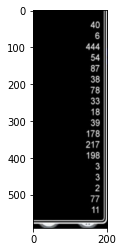

In [27]:
plt.imshow(plt.imread("processed_images/" + user_name + ".jpeg"))

In [28]:
result = reader.readtext(
    "processed_images/" + user_name + ".jpeg",
    decoder="greedy",
    detail=0,
    mag_ratio=2.5,
    text_threshold=0.6,
    low_text=0.339
)

In [29]:
result

['40',
 '6',
 '444',
 '54',
 '87',
 '38',
 '78',
 '33',
 '18',
 '39',
 '178',
 '217',
 '198',
 '3',
 '3',
 '2',
 '77',
 '11']

In [30]:
stats = [img_path.rsplit('/')[-1].split(".")[0]]
for r in result:
    if r.isnumeric():
        # print(r)
        stats.append(int(r))

stats, len(stats)

(['youtuber',
  40,
  6,
  444,
  54,
  87,
  38,
  78,
  33,
  18,
  39,
  178,
  217,
  198,
  3,
  3,
  2,
  77,
  11],
 19)

In [31]:
assert len(stats) == 19

In [32]:
stats = stats + list(np.zeros(6, dtype='int'))

In [33]:
df = pd.read_csv('/content/drive/My Drive/among_us_stats/info.csv')

In [34]:
df = df.append(pd.Series(stats, df.columns), ignore_index=True)

In [35]:
df["Tasks Completion Rate"] = df["All Tasks Completed"] * 100 / df["Games Started"]
df["Game completion rate"] = df["Games Finished"] * 100 / df["Games Started"]
df["Impostor win rate"] = (df["Impostor Vote Wins"] + df["Impostor Kill Wins"] + df["Impostor Sabotage Wins"]) * 100 / df["Times Impostor"]
df["Crewmate win rate"] = (df["Crewmate Vote Wins"] + df["Crewmate Task Wins"]) * 100 / df["Times Crewmate"]
df["Total win rate"] = (df["Crewmate Vote Wins"] + df["Crewmate Task Wins"] + df["Impostor Vote Wins"] + df["Impostor Kill Wins"] + df["Impostor Sabotage Wins"]) * 100 / df["Games Started"]
df["Ejection Rate"] = df["Times Ejected"] * 100 / df["Games Started"]

df.sort_values("Total win rate", ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)

In [36]:
df[["Player Name", "Total win rate", "Games Started", "Tasks Completion Rate", "Ejection Rate"]]

,Player Name,Total win rate,Games Started,Tasks Completion Rate,Ejection Rate
0,jd,65.610860,221,16.742081,18.552036
1,sagar,62.831858,226,20.796460,15.486726
2,ashok,56.756757,37,18.918919,29.729730
3,sannata,56.521739,184,11.413043,17.934783
4,vt,55.970149,134,9.701493,14.925373
5,seedhe_maut,54.128440,109,31.192661,22.018349
6,gamerzoner,54.022989,87,16.091954,8.045977
7,larry,53.363229,223,19.730942,21.973094
8,don,45.714286,35,14.285714,22.857143
9,situ,45.652174,92,8.695652,17.391304


Info for Player youtuber

Total win rate: 44.24%
Impostor win rate: 20.51%
Crewmate win rate: 49.44%
All tasks completion rate: 24.88%
---




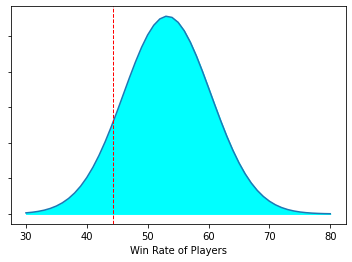

You are better than 17% of the players


In [39]:
row = df.loc[df["Player Name"] == user_name]

print("Info for Player", row["Player Name"].values[0])      
print()
print("Total win rate: {:.2f}%".format(row["Total win rate"].values[0]))
print("Impostor win rate: {:.2f}%".format(row["Impostor win rate"].values[0]))
print("Crewmate win rate: {:.2f}%".format(row["Crewmate win rate"].values[0]))
print("All tasks completion rate: {:.2f}%".format(row["Tasks Completion Rate"].values[0]))
print("---\n\n")

personal_winrate = row["Total win rate"].values[0]

mean, stdev = df[["Total win rate"]].mean().values[0], df[["Total win rate"]].std().values[0]

fig, ax = plt.subplots(1)

x = range(30, 81)
y = norm.pdf(x, mean, stdev)
ax.plot(x, y)
ax.fill_between(x, 0, y, color="cyan")
ax.axvline(personal_winrate, color='red', linestyle='dashed', linewidth=1)
ax.set_yticklabels([])
ax.set_xlabel("Win Rate of Players")

plt.show()

percentile = percentileofscore(df[["Total win rate"]], personal_winrate)
print(f"You are better than {percentile:.0f}% of the players")

In [22]:
%%writefile app.py

import os
import cv2
import easyocr
import numpy as np
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt


from glob import glob
from enum import Enum
from typing import Union
from io import BytesIO, StringIO
from scipy.stats import norm, percentileofscore

st.set_option("deprecation.showfileUploaderEncoding", False)

FILE_TYPES = ["png", "jpeg", "jpg"]
reader = easyocr.Reader(["en"])
PAGE_CONFIG = {"page_title": "StColab.io", "layout": "centered"}
st.beta_set_page_config(**PAGE_CONFIG)
DATA_DIR = "/content/drive/My Drive/among_us_stats"


class FileType(Enum):
    IMAGE = "Image"


def get_file_type(file: Union[BytesIO, StringIO]) -> FileType:
    if isinstance(file, BytesIO):
        return FileType.IMAGE


def get_segment_crop(img, tol=0, mask=None):
    if mask is None:
        mask = img > tol
    return img[np.ix_(mask.any(1), mask.any(0))]


def preprocess_image(user_name, img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    thresh_inv = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]

    # Blur the image
    blur = cv2.GaussianBlur(thresh_inv, (1, 1), 0)

    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # find contours
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    mask = np.ones(img.shape[:2], dtype="uint8") * 255
    for c in contours:
        # get the bounding rect
        x, y, w, h = cv2.boundingRect(c)
        if w * h > 0.2 * img.shape[0] * img.shape[1]:
            cv2.rectangle(mask, (x, y), (x + w, y + h), (0, 0, 255), -1)

    res_final = cv2.bitwise_and(img, img, mask=cv2.bitwise_not(mask))
    mask_out = cv2.subtract(cv2.bitwise_not(mask), thresh_inv)

    result = get_segment_crop(img, mask=cv2.bitwise_not(mask))

    width = 600
    height = 650
    dim = (width, height)

    # resize image
    result = cv2.resize(result, dim, interpolation=cv2.INTER_AREA)

    result = result[:-30, int(0.666 * result.shape[1]) :]

    # cv2_imshow(result)
    cv2.imwrite("processed_images/" + user_name + ".jpeg", result)


def get_reply(user_name, img_path):

    preprocess_image(user_name, img_path)

    result = reader.readtext(
        "processed_images/" + user_name + ".jpeg",
        decoder="greedy",
        detail=0,
        text_threshold=0.6,
        low_text=0.339,
        mag_ratio=2.5
    )

    stats = [user_name]
    for r in result:
        if r.isnumeric():
            stats.append(int(r))

    assert len(stats) == 19
    stats = stats + list(np.zeros(6, dtype="int"))
    df = pd.read_csv(os.path.join(DATA_DIR, "info.csv"))
    df = df.append(pd.Series(stats, df.columns), ignore_index=True)

    df["Tasks Completion Rate"] = df["All Tasks Completed"] * 100 / df["Games Started"]
    df["Game completion rate"] = df["Games Finished"] * 100 / df["Games Started"]
    df["Impostor win rate"] = (
        (
            df["Impostor Vote Wins"]
            + df["Impostor Kill Wins"]
            + df["Impostor Sabotage Wins"]
        )
        * 100
        / df["Times Impostor"]
    )
    df["Crewmate win rate"] = (
        (df["Crewmate Vote Wins"] + df["Crewmate Task Wins"])
        * 100
        / df["Times Crewmate"]
    )
    df["Total win rate"] = (
        (
            df["Crewmate Vote Wins"]
            + df["Crewmate Task Wins"]
            + df["Impostor Vote Wins"]
            + df["Impostor Kill Wins"]
            + df["Impostor Sabotage Wins"]
        )
        * 100
        / df["Games Started"]
    )
    df["Ejection Rate"] = df["Times Ejected"] * 100 / df["Games Started"]

    df.sort_values("Total win rate", ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)

    row = df.loc[df["Player Name"] == user_name]

    "Info for Player", row["Player Name"].values[0]

    "Total win rate:", row["Total win rate"].values[0]

    "Impostor win rate:", row["Impostor win rate"].values[0]

    "Crewmate win rate:", row["Crewmate win rate"].values[0]

    "All tasks completion rate:", row["Tasks Completion Rate"].values[0]

    st.text("---\n\n")

    personal_winrate = row["Total win rate"].values[0]

    mean, stdev = (
        df[["Total win rate"]].mean().values[0],
        df[["Total win rate"]].std().values[0],
    )

    fig, ax = plt.subplots(1)

    x = range(30, 81)
    y = norm.pdf(x, mean, stdev)
    ax.plot(x, y)
    ax.fill_between(x, 0, y, color="cyan")
    ax.axvline(personal_winrate, color="red", linestyle="dashed", linewidth=1)
    ax.set_yticklabels([])
    ax.set_xlabel("Win Rate of Players")

    st.pyplot(fig)

    percentile = percentileofscore(df[["Total win rate"]], personal_winrate)

    "You are better than", round(percentile), "% of the players"


def main():
    st.title("Among Us Stats Checker")
    menu = ["Home", "Leaderboard", "About"]
    choice = st.sidebar.selectbox("Menu", menu)
    if choice == "Home":
        user_name = st.text_input("Username", "")
        file = st.file_uploader("Upload file", type=FILE_TYPES)
        show_file = st.empty()
        if not file:
            show_file.info("Please upload a file of type: " + ", ".join(FILE_TYPES))
            return

        file_type = get_file_type(file)

        img_path = user_name + ".jpeg"

        f = open(img_path, "wb")
        f.write(file.getvalue())

        file.close()
        f.close()

        get_reply(user_name, img_path)


if __name__ == "__main__":
    main()

Writing app.py


In [23]:
!streamlit run app.py &>/dev/null&

In [24]:
from pyngrok import ngrok

ngrok.set_auth_token("1iPi6Bps52TiPC0hquRoEPW85nL_6vSHuqvzsF3gze1qgQtvi")
public_url = ngrok.connect(port='8501')
public_url

'http://9f5970f00665.ngrok.io'